In [2]:
import sys
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np

sys.setrecursionlimit(1500000000)

In [84]:
def merge_ch(image):
    h, w, ch = image.shape
    if ch > 1:
        image = np.mean(image, axis=2)
    return image

In [3]:
def threshold(image, val=0.0, reverse=False):
    h, w, ch = image.shape
    if ch > 1:
        image = np.mean(img, axis=2)

    if reverse:
        background = image[:, :] > val
    else:
        background = image[:, :] < val
        
    image[~background] = 255
    image[background] = 0

    return image

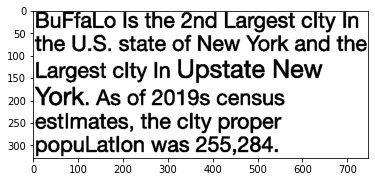

In [7]:
# apply Sauvola local adaptive thresholding
img = cv2.imread('data/test_img.jpg')
bin_img = threshold(img, np.mean(img)+10)
_ = plt.imshow(bin_img, cmap='gray')

libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG


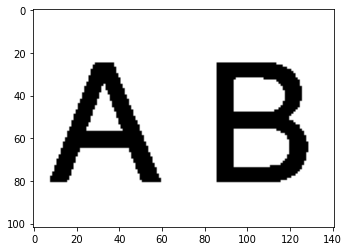

In [4]:
img = cv2.imread('2.png')
bin_img = threshold(img, np.mean(img)+10)
_ = plt.imshow(bin_img, cmap='gray')

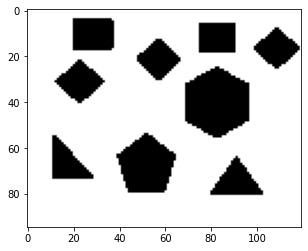

In [6]:
img = cv2.imread('n.png')
bin_img = threshold(img, np.mean(img)+10, reverse=True)
_ = plt.imshow(bin_img, cmap='gray')

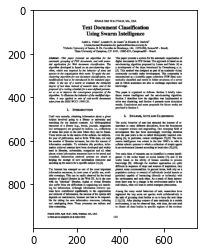

In [68]:
img = cv2.imread('many.png')
bin_img = threshold(img, np.mean(img)+10)
_ = plt.imshow(bin_img, cmap='gray')

In [117]:
np.unique(bin_img), bin_img.shape

(array([  0., 255.]), (396, 502))

In [69]:
FOREGROUND = 0.
BACKGROUND = 255.

def get_neighbours(k):
    neighbours = [
        [1, 0],
        [0, 1],
        [-1, 0],
        [0, -1],
    ]
    if k == 8:
        diag_neighbours = [
            [-1, -1],
            [1, 1],
            [-1, 1],
            [1, -1]
        ]
        neighbours += diag_neighbours

    return neighbours

def connected_components(arr, foreground, background, n_dir=8):
    arr = arr.copy()
    print(f'arr.shape : {arr.shape}')
    height, width = len(arr), len(arr[0])
    components = defaultdict(dict)
    visited = set()
    
    def dfs(i, j, p):
#         print(i, j, p)
        nonlocal height, width, arr, visited
        if i < 0 or i >= height or j < 0 or j >= width or arr[i][j] == -1 or (i, j) in visited:
            return
       
        visited.add((i, j))
        arr[i][j] = p
        neighbour_idx = get_neighbours(n_dir)
        for x, y in neighbour_idx:
            dfs(i+x, j+y, p)

                
    n_component = 1
    p = 1
    
    for i in range(height):
        for j in range(width):
            if arr[i][j] == background:
                arr[i][j] = -1
                
    print(np.unique(arr))
    
    for i in range(height):
        for j in range(width):
            if arr[i][j] == foreground:
                dfs(i, j, p)
                p += 1
                
    for i in range(height):
        for j in range(width):
            if arr[i][j] > 0:
                if i < components[arr[i][j]].get('left', float('inf')):
                    components[arr[i][j]]['left'] = i  
                if i > components[arr[i][j]].get('right', float('-inf')):
                    components[arr[i][j]]['right'] = i
                    
                if j < components[arr[i][j]].get('top', float('inf')):
                    components[arr[i][j]]['top'] = j  
                if j > components[arr[i][j]].get('bottom', float('-inf')):
                    components[arr[i][j]]['bottom'] = j
    
                
    return components
                

temp = connected_components(
    bin_img,
    foreground=0.,
    background=255.,
)
temp

arr.shape : (1000, 755)
[-1.  0.]


defaultdict(dict,
            {1.0: {'left': 46, 'right': 55, 'top': 282, 'bottom': 320},
             2.0: {'left': 46, 'right': 54, 'top': 324, 'bottom': 329},
             3.0: {'left': 46, 'right': 55, 'top': 331, 'bottom': 348},
             4.0: {'left': 46, 'right': 55, 'top': 352, 'bottom': 363},
             5.0: {'left': 46, 'right': 54, 'top': 364, 'bottom': 379},
             6.0: {'left': 46, 'right': 56, 'top': 380, 'bottom': 418},
             7.0: {'left': 46, 'right': 56, 'top': 423, 'bottom': 444},
             8.0: {'left': 46, 'right': 55, 'top': 449, 'bottom': 473},
             9.0: {'left': 71, 'right': 88, 'top': 225, 'bottom': 239},
             10.0: {'left': 71, 'right': 88, 'top': 278, 'bottom': 306},
             11.0: {'left': 71, 'right': 88, 'top': 391, 'bottom': 406},
             12.0: {'left': 71, 'right': 88, 'top': 408, 'bottom': 444},
             13.0: {'left': 71, 'right': 74, 'top': 447, 'bottom': 450},
             14.0: {'left': 71, 'right': 8

In [10]:
def gaussian_kernel(size, sigma):
    kernel_1d = np.linspace(- (size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(kernel_1d) / np.square(sigma))
    kernel_2d = np.outer(gauss, gauss)
    return kernel_2d / np.sum(kernel_2d)

In [11]:
def convolve(image, kernel, stride, padding=0):
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    h = ((img_h - k_h + (2 * padding)) // stride) + 1
    w = ((img_w - k_w + (2 * padding)) // stride) + 1

    kernel = np.flipud(np.fliplr(kernel))
    output = []
    image = np.pad(image, pad_width=padding)

    for i in range(0, img_h-k_h+1, stride):
        for j in range(0, img_w-k_w+1, stride):
            region = image[i:i+k_h, j:j+k_w]
            output.append(np.multiply(region, kernel).sum())

    output = np.asarray(output).reshape(h, w)
    return output

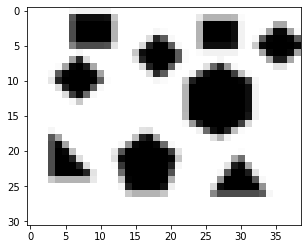

In [12]:
kernel = gaussian_kernel(size=5, sigma=1)
temp = convolve(bin_img, kernel, stride=3)
_ = plt.imshow(temp, cmap='gray')

In [66]:
def gaussian_pyramid(image, n, kernel_len=5, sigma=1):
    image = image.copy()
    res = []
    for i in range(n):
        image = convolve(
            image=image,
            kernel=gaussian_kernel(
                size=kernel_len,
                sigma=sigma,
            ),
            stride=2,
        )
        res.append(image)

    return res

In [182]:
temp = gaussian_pyramid(image=bin_img, n=5)

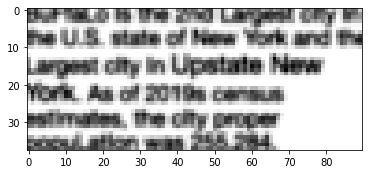

In [183]:
_ = plt.imshow(temp[2], cmap='gray')

In [55]:
def expand(image, factor=2):
    "Nearest neighbour interpolation"
    img_h, img_w = image.shape
    h, w = img_h * factor, img_w * factor
    output = []

    for i in range(img_h):
        for j in range(img_w):
            for _ in range(factor):
                output.append(image[i][j])
        for _ in range(factor-1):
            output += output[-img_w*factor:]

    output = np.asarray(output).reshape(h, w)
    return output

In [85]:
a = cv2.imread('data/characters/a.jpg')
a = merge_ch(a)
a_pyr = gaussian_pyramid(image=a, n=2)

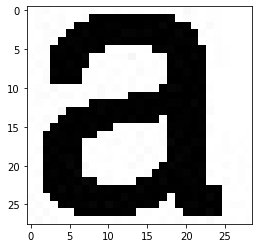

In [86]:
_ = plt.imshow(a, cmap='gray')

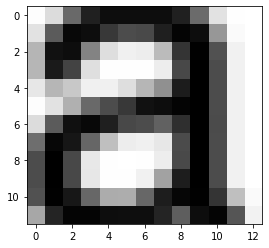

In [88]:
_ = plt.imshow(a_pyr[0], cmap='gray')

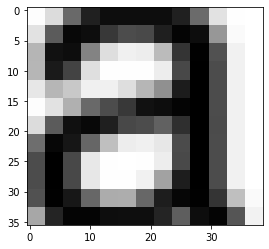

In [91]:
a2 = expand(a_pyr[0], 3)
_ = plt.imshow(a2, cmap='gray')